In [12]:
# Import Statements
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from scipy import sparse
from keras.models import Sequential
from keras.layers import Dense

# Read the news dataset
df=pd.read_csv(r'train.csv')
print(df.iloc[0])
print(df.shape)
df.head()

id                                                        0
title     House Dem Aide: We Didn’t Even See Comey’s Let...
author                                        Darrell Lucus
text      House Dem Aide: We Didn’t Even See Comey’s Let...
label                                                     1
Name: 0, dtype: object
(20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [13]:
# Download useful packages from nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
# Enforce correct types over the dataset features
df['title'] = df['title'].astype('str') 
df['text'] = df['text'].astype('str')
news=df
news.drop(['id', 'author'], axis='columns', inplace=True)
news.dropna(subset=['title','text','label'], inplace=True)
 
news.head()

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


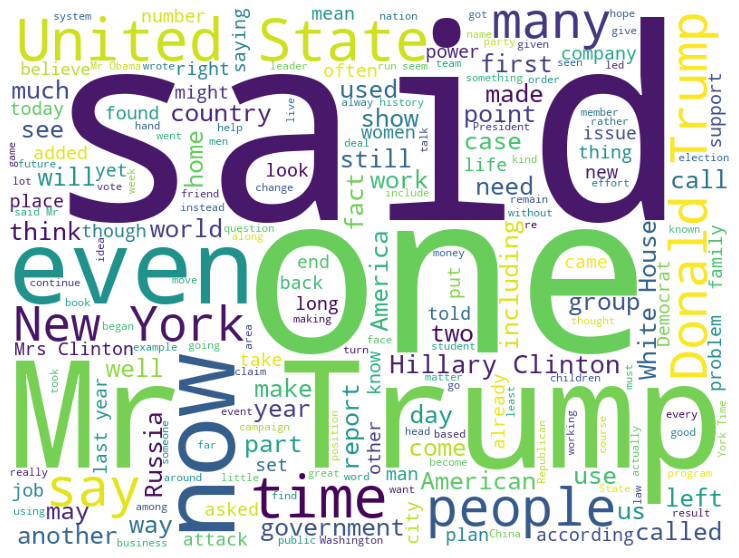

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
cloud(' '.join(news['text']))

# 1)Sentimental Features
## This section extracts 2 features:
## a) Polarity ( 1,0,-1 based on positive, neutral and negative news)
## b) Sentiment score or subjective score 




In [17]:
def cleaning(raw_news):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(news_words)
clean_text=[]
for i in news['text']:
  clean_text.append(cleaning(i))

news['clean_text'] = clean_text
news.head()

,title,text,label,clean_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide we didn t even see comey s lett...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,why the truth might get you fired october the ...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed in single us airstrike...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,print an iranian woman has been sentenced to s...


In [83]:
polar=[]
cmp_score=[]
from textblob import TextBlob
def senti(x):
    return TextBlob(x).sentiment  
for i in news['clean_text']:
  t=cleaning(i)
  x=senti(t)
  polar.append(x[0])
  cmp_score.append(x[1])


news['polarity'] = polar
news['sentiment_score'] = cmp_score


In [84]:
# Function to obtain the sentiment vector of a tuple
import warnings
import nltk.sentiment
warnings.filterwarnings('ignore')
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    return sentimentVector

In [85]:
# Calculate the Sentiment Vector, Polarity and Sentiment Score of each tuple and append into the dataset
sentiment = []
polar = []
cmp_score = []
for i in news['clean_text']:
    get_pols = get_polarity_type(i)
    sentiment.append(get_pols[1:])
     
    
#news['sentiment_vector'] = sentiment


In [86]:
# View the modified dataset
news.head()

,title,text,label,clean_text,polarity,sentiment_score
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide we didn t even see comey s lett...,-0.013339,0.486661
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,ever get the feeling your life circles the rou...,0.100880,0.495110
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,why the truth might get you fired october the ...,0.050606,0.392070
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed in single us airstrike...,0.016720,0.256508
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,print an iranian woman has been sentenced to s...,-0.012500,0.112500


# 2)Syntax Based Features
## This section extracts 6 Syntax-based features:
## a)characters count(with spaces)
## b)words count
## c)Uppercase word count
## d)Stop word count
## e)word count in the title
## f)word density

In [19]:
# Compute the Syntax-based features
import string 
total_words=0
char_count=[]
word_count=[]
uword_count=[]
tword_count=[]
stop_count=[]
word_density=[]
for i in news['text']:
  char_count.append(len(i))
  word_count.append(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))
  uword_count.append(sum(([i.strip(string.punctuation).isupper() for i in i.split()])))
  news_words = nltk.word_tokenize(i)
  total_words+=len(list(set(news_words)))
  stops = set(nltk.corpus.stopwords.words("english"))
  words = [w for w in  news_words  if w in stops]
  stop_count.append(len(words))
  #fd = nltk.FreqDist(words)
  #for j in fd:
    #fd[j]=fd[j]/(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))
  #word_density.append(fd)

for i in news['title']:
  tword_count.append(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))

# Append the calculated features to the existing dataset
news['char_count'] = char_count
news['word_count'] = word_count
news['title_word_count'] = tword_count
news['stop_word_count'] = stop_count
news['upper_case_word_count'] = uword_count

In [20]:
# View the modified dataset
news.head()

,title,text,label,clean_text,char_count,word_count,title_word_count,stop_word_count,upper_case_word_count
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide we didn t even see comey s lett...,4930,769,12,364,9
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,ever get the feeling your life circles the rou...,4160,659,8,305,7
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,why the truth might get you fired october the ...,7692,1195,7,523,19
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed in single us airstrike...,3237,531,9,216,18
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,print an iranian woman has been sentenced to s...,938,140,14,61,0


# 3) Grammatical Features
## This section computes 5 Grammatical features:
## a)Noun count
## b)Verb count
## c)Adjective count
## d)Pronoun count
## e)Adverb count

In [89]:
# Calculate the Grammatical Features
from collections import Counter

noun_count=[]
verb_count=[]
adjective_count=[]
pronoun_count=[]
adverb_count=[]
lexical_density=[]
word_count=[]
index = 0

for i in news['clean_text']:
  news_words = nltk.word_tokenize(i)
  text = nltk.Text(news_words)
  tags = nltk.pos_tag(text)
  counts=(Counter(tag for word,tag in tags))

  word_count.append(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))
  
  noun_count.append(counts['NN']+counts['NNS']+counts['NNP'])
  adjective_count.append(counts['JJ']+counts['JJR']+counts['JJS'])
  verb_count.append(counts['VB']+counts['VBD']+counts['VBG']+counts['VBN']+counts['VBP']+counts['VBZ'])
  pronoun_count.append(counts['PRP']+counts['PRP$']+counts['WP']+counts['WP$'])
  adverb_count.append(counts['RB']+counts['RBR']+counts['RBS']+counts['WRB'])
  lexical_density.append((noun_count[index] + verb_count[index] + adjective_count[index] + adverb_count[index]) / word_count[index])
  


# Append the calculated features to the existing dataset
news['lexical_density'] = lexical_density
news['noun_count'] = noun_count
news['verb_count'] = verb_count
news['adjective_count'] = adjective_count
news['pronoun_count'] = pronoun_count
news['adverb_count'] = adverb_count

In [90]:
# View the modified dataset
news.head()

,title,text,label,clean_text,polarity,sentiment_score,char_count,word_count,title_word_count,stop_word_count,upper_case_word_count,lexical_density,noun_count,verb_count,adjective_count,pronoun_count,adverb_count
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide we didn t even see comey s lett...,-0.013339,0.486661,4930,769,12,364,9,0.611905,218,154,96,62,46
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,ever get the feeling your life circles the rou...,0.100880,0.495110,4160,659,8,305,7,0.611905,179,112,67,64,46
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,why the truth might get you fired october the ...,0.050606,0.392070,7692,1195,7,523,19,0.611905,340,209,146,84,84
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed in single us airstrike...,0.016720,0.256508,3237,531,9,216,18,0.611905,149,112,55,33,18
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,print an iranian woman has been sentenced to s...,-0.012500,0.112500,938,140,14,61,0,0.611905,50,32,9,7,3


# 4)Readability Features
## Compute 6 Readability Features:
## a)Flesch Reading Ease 
## b)Automated Readability Index
## c)Gunning Fog index 
## d)Flesch-Kincaid score 
## e)The SMOG Index 
## f)Linsear Write formula

In [91]:
# Function to count number of syllables in a word
def syllables(word):
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return count

In [92]:
# Import statements and Declarations
from nltk.tokenize import sent_tokenize
import math
fre=[]
ari=[]
gfi=[]
fks=[]
smog=[]
lwf=[]


# Use number of syllables in the sentence to compute the various Readability Scores
for i in news['text']:
  syllable_count={}
  ncc=len(i)
  nwc=(sum([i.strip(string.punctuation).isalpha() for i in i.split()]))
  uword_count.append(sum(([i.strip(string.punctuation).isupper() for i in i.split()])))
  news_words = nltk.word_tokenize(i)
  total_syllables=0
  hw=0
  ps=0
  ew=0
  
  for j in news_words:
    syllable_count[j]=syllables(j)
    total_syllables+=syllable_count[j]
    if syllable_count[j]>2:
      hw+=1
    if syllable_count[j]>1:
      ps+=1
    if syllable_count[j]<4:
      ew+=1
  news_sentences = sent_tokenize(i)
  nst=len(news_sentences)
  asl=nwc/nst if nst!=0 else 0 
  asw=total_syllables/nwc if nwc!=0 else 0
  phw=100*(hw/nwc if nwc!=0 else 0)
  

  fre.append(206.835 -(1.015 *asl) - (84.6 *asw))
  ari.append(4.71*(ncc/nwc if nwc!=0 else 0)+ 0.5*asl)
  gfi.append(0.4*(asl+phw))
  fks.append(3+math.sqrt(ps))
  smog.append((0.39 *asl) + (11.8 *asw) -15.59)
  x=100 * (nst/nwc if nwc!=0 else 0)
  lwf.append((((100-(100 * (1-(hw/nwc if nwc!=0 else 0))))+(3*(100 *(ew/nwc if nwc!=0 else 0))))/x) if x!=0 else 0)


# Append the computed scores to the dataset
news['fre'] = fre
news['ari'] = ari
news['gfi'] = gfi
news['fks'] = fks
news['smog'] = smog
news['lwf'] = lwf

In [93]:
# View the modified dataset
news.head()

,title,text,label,clean_text,polarity,sentiment_score,char_count,word_count,title_word_count,stop_word_count,upper_case_word_count,lexical_density,noun_count,verb_count,adjective_count,pronoun_count,adverb_count,fre,ari,gfi,fks,smog,lwf
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide we didn t even see comey s lett...,-0.013339,0.486661,4930,769,12,364,9,0.611905,218,154,96,62,46,25.780552,40.587341,14.711433,21.220867,14.826729,76.216216
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,ever get the feeling your life circles the rou...,0.100880,0.495110,4160,659,8,305,7,0.611905,179,112,67,64,46,26.123869,41.094391,16.252022,18.811388,15.260881,85.689655
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,why the truth might get you fired october the ...,0.050606,0.392070,7692,1195,7,523,19,0.611905,340,209,146,84,84,21.568810,42.033109,17.238658,25.113344,16.071917,85.372549
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed in single us airstrike...,0.016720,0.256508,3237,531,9,216,18,0.611905,149,112,55,33,18,35.358079,38.545706,15.098305,17.387495,13.213333,68.111111
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,print an iranian woman has been sentenced to s...,-0.012500,0.112500,938,140,14,61,0,0.611905,50,32,9,7,3,1.963571,45.557000,19.771429,11.366600,19.941429,105.600000


In [94]:
# Convert the final dataset into csv for use later
news.to_csv('processed_data.csv')

# 5) Final Model

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re


from keras.models import Sequential
from keras.layers import Dense

In [25]:
# Read the processed data
from sklearn.utils import shuffle
df = pd.read_csv("processed_data.csv")
#df = shuffle(df)
feature_set = df.iloc[:, 5:]
labels = df.iloc[:, 3]
print(df.shape)

feature_set_1 = feature_set.iloc[:, 0:-6]
feature_set_2 = feature_set.iloc[:, -6:]
feature_set_3 = feature_set
feature_set.head()

(20800, 24)


,polarity,sentiment_score,char_count,word_count,title_word_count,stop_word_count,upper_case_word_count,lexical_density,noun_count,verb_count,adjective_count,pronoun_count,adverb_count,fre,ari,gfi,fks,smog,lwf
0,-0.013339,0.486661,4930,769,12,364,9,0.611905,218,154,96,62,46,25.780552,40.587341,14.711433,21.220867,14.826729,76.216216
1,0.100880,0.495110,4160,659,8,305,7,0.611905,179,112,67,64,46,26.123869,41.094391,16.252022,18.811388,15.260881,85.689655
2,0.050606,0.392070,7692,1195,7,523,19,0.611905,340,209,146,84,84,21.568810,42.033109,17.238658,25.113344,16.071917,85.372549
3,0.016720,0.256508,3237,531,9,216,18,0.611905,149,112,55,33,18,35.358079,38.545706,15.098305,17.387495,13.213333,68.111111
4,-0.012500,0.112500,938,140,14,61,0,0.611905,50,32,9,7,3,1.963571,45.557000,19.771429,11.366600,19.941429,105.600000


In [15]:
# Declare the Sequential ANN models
model1 = Sequential()
model2 = Sequential()
model3 = Sequential()

In [16]:
# Add the necessary layers to define the models
# Model 1
model1.add(Dense(activation='relu',kernel_initializer='uniform', units=4,input_dim=13)) # First Hidden Layer
model1.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # Second Hidden Layer
model1.add(Dense(activation='sigmoid', units=1)) # Output Layer

# Model 2
model2.add(Dense(activation='relu',kernel_initializer='uniform', units=4,input_dim=6)) # First Hidden Layer
model2.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # Second Hidden Layer
model2.add(Dense(activation='sigmoid', units=1)) # Output Layer

# Model 3
model3.add(Dense(activation='relu',kernel_initializer='uniform', units=4,input_dim=19)) # First Hidden Layer
model3.add(Dense(activation='relu',kernel_initializer='uniform', units=4)) # Second Hidden Layer
model3.add(Dense(activation='sigmoid', units=1)) # Output Layer

In [17]:

# Compile the models
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Fit the 1st model to the first Feature Set
from sklearn.model_selection import train_test_split
fs1_train, fs1_test, labels_train, labels_test = train_test_split(feature_set_1, labels, test_size=0.2)
m1=model1.fit(fs1_train, labels_train,validation_split=0.25, epochs=50,shuffle=True, batch_size=10)
_, accuracy = model1.evaluate(fs1_test, labels_test)

Epoch 1/50
1248/1248 [==============================] - 3s 2ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6933 - val_accuracy: 0.4925
Epoch 2/50
1248/1248 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5075
Epoch 3/50
1248/1248 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6932 - val_accuracy: 0.4925
Epoch 4/50
1248/1248 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6933 - val_accuracy: 0.4925
Epoch 5/50
1248/1248 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4925
Epoch 6/50
1248/1248 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.4925
Epoch 7/50
1248/1248 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy:

In [19]:
# Fit the 2st model to the 2nd Feature Set
from sklearn.model_selection import train_test_split
fs2_train, fs2_test, labels_train, labels_test = train_test_split(feature_set_2, labels, test_size=0.2)
m2=model2.fit(fs2_train, labels_train,validation_split=0.33,shuffle=True, epochs=50, batch_size=10)
_, accuracy = model2.evaluate(fs2_test, labels_test)

Epoch 1/50
1115/1115 [==============================] - 2s 1ms/step - loss: 0.6687 - accuracy: 0.5813 - val_loss: 0.6263 - val_accuracy: 0.6672
Epoch 2/50
1115/1115 [==============================] - 2s 1ms/step - loss: 0.6353 - accuracy: 0.6661 - val_loss: 0.6209 - val_accuracy: 0.6741
Epoch 3/50
1115/1115 [==============================] - 2s 1ms/step - loss: 0.6233 - accuracy: 0.6693 - val_loss: 0.6146 - val_accuracy: 0.6790
Epoch 4/50
1115/1115 [==============================] - 2s 1ms/step - loss: 0.6216 - accuracy: 0.6663 - val_loss: 0.6099 - val_accuracy: 0.6775
Epoch 5/50
1115/1115 [==============================] - 2s 1ms/step - loss: 0.6209 - accuracy: 0.6622 - val_loss: 0.6039 - val_accuracy: 0.6801
Epoch 6/50
1115/1115 [==============================] - 2s 1ms/step - loss: 0.6083 - accuracy: 0.6748 - val_loss: 0.5991 - val_accuracy: 0.6881
Epoch 7/50
1115/1115 [==============================] - 2s 1ms/step - loss: 0.6073 - accuracy: 0.6689 - val_loss: 0.6017 - val_accuracy:

In [20]:
# Fit the 3rd model to the 3rd Feature Set
from sklearn.model_selection import train_test_split
fs3_train, fs3_test, labels_train, labels_test = train_test_split(feature_set_3, labels, test_size=0.2)
m3=model3.fit(fs3_train, labels_train,validation_split=0.33,shuffle=True, epochs=50, batch_size=10)
_, accuracy = model3.evaluate(fs3_test, labels_test)

Epoch 1/50
1115/1115 [==============================] - 2s 2ms/step - loss: 0.6742 - accuracy: 0.5581 - val_loss: 0.6323 - val_accuracy: 0.6429
Epoch 2/50
1115/1115 [==============================] - 2s 2ms/step - loss: 0.6296 - accuracy: 0.6476 - val_loss: 0.6352 - val_accuracy: 0.6218
Epoch 3/50
1115/1115 [==============================] - 2s 2ms/step - loss: 0.6036 - accuracy: 0.6635 - val_loss: 0.5894 - val_accuracy: 0.6823
Epoch 4/50
1115/1115 [==============================] - 2s 2ms/step - loss: 0.5905 - accuracy: 0.6785 - val_loss: 0.6282 - val_accuracy: 0.6642
Epoch 5/50
1115/1115 [==============================] - 2s 2ms/step - loss: 0.6036 - accuracy: 0.6636 - val_loss: 0.5751 - val_accuracy: 0.7017
Epoch 6/50
1115/1115 [==============================] - 2s 2ms/step - loss: 0.5890 - accuracy: 0.6799 - val_loss: 0.6106 - val_accuracy: 0.6542
Epoch 7/50
1115/1115 [==============================] - 2s 2ms/step - loss: 0.5835 - accuracy: 0.6867 - val_loss: 0.5781 - val_accuracy:

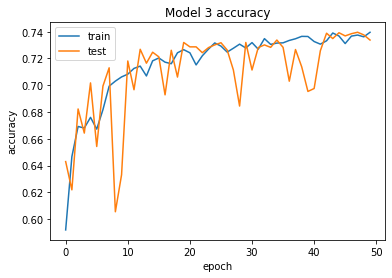

In [22]:
import matplotlib.pyplot as plt
plt.plot(m3.history['accuracy'])
plt.plot(m3.history['val_accuracy'])
plt.title('Model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


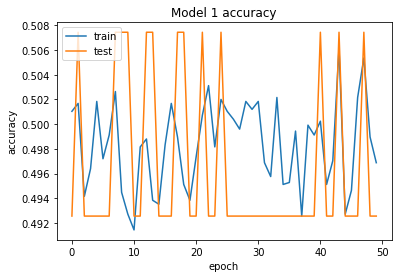

In [24]:
import matplotlib.pyplot as plt
plt.plot(m1.history['accuracy'])
plt.plot(m1.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


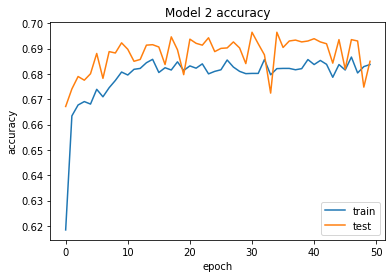

In [23]:
import matplotlib.pyplot as plt
plt.plot(m2.history['accuracy'])
plt.plot(m2.history['val_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()